Objective:
    Apply classical machine learning models to conduct relation extraction

In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
#!pip install --upgrade transformers
#!pip install torch tokenizers
#! pip install spacy 
#!pip install datasets
import spacy
from datasets import load_dataset
from datasets import Dataset, ClassLabel, Sequence, load_dataset, load_metric
import re
import math
from math import sqrt
from collections import Counter
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification, pipeline, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PaddingStrategy
#!pip install seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import *
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import catboost
from catboost.utils import get_roc_curve
from catboost.utils import eval_metric

/home/nankli/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 103: integrity checks failed (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
#download embedding model from Spacy
!python -m spacy download en_core_web_md

/home/nankli/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 103: integrity checks failed (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
     |████████████████████████████████| 42.8 MB 5.2 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


### Load data

In [3]:
data1 = load_dataset('ade_corpus_v2', "Ade_corpus_v2_classification")
df1 = pd.DataFrame(data1["train"])
df1.to_csv("ade_relation_train.csv", index=None) 


Found cached dataset ade_corpus_v2 (/home/nankli/.cache/huggingface/datasets/ade_corpus_v2/Ade_corpus_v2_classification/1.0.0/940d61334dbfac6b01ac5d00286a2122608b8dc79706ee7e9206a1edb172c559)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
df1

,text,label
0,Intravenous azithromycin-induced ototoxicity.,1
1,"Immobilization, while Paget's bone disease was...",1
2,Unaccountable severe hypercalcemia in a patien...,1
3,METHODS: We report two cases of pseudoporphyri...,1
4,METHODS: We report two cases of pseudoporphyri...,1
...,...,...
23511,"At autopsy, the liver was found to be small, s...",0
23512,"Physical exam revealed a patient with aphasia,...",0
23513,At the time when the leukemia appeared seven o...,0
23514,The American Society for Regional Anesthesia a...,0


### Preprocessing

In [5]:
# Load pre-trained word embeddings using spaCy
nlp = spacy.load("en_core_web_md")

# Split the dataset into training and testing sets
texts = df1['text'] 
labels = df1['label'] 
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Extract features from text using pre-trained word embeddings
X_train = np.array([nlp(text).vector for text in X_train])
X_test = np.array([nlp(text).vector for text in X_test])


### Define class weights

In [6]:
def generate_weights(method='INS',y_train=y_train):
    #support two methods: INS: inverse of number of samples
    #ISNS: inverse of square root of number of samples
    if method == 'INS':   
        counter = dict(Counter(y_train))
        ratio = counter[0]/counter[1]
        weights={0:1,1:ratio}
    elif method == 'ISNS':
        counter = dict(Counter(y_train))
        ratio = math.sqrt(counter[0])/math.sqrt(counter[1])
        weights={0:1,1:ratio}
    return weights

In [7]:
weights = generate_weights(method='ISNS')
weights

{0: 1, 1: 1.5674237929047024}

### SVM model

In [8]:
# Train an SVM model
svm = SVC(kernel='linear', class_weight='balanced')
svm.fit(X_train, y_train)

SVC(class_weight='balanced', kernel='linear')

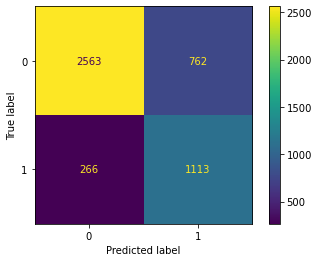

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      3325
           1       0.59      0.81      0.68      1379

    accuracy                           0.78      4704
   macro avg       0.75      0.79      0.76      4704
weighted avg       0.81      0.78      0.79      4704



In [9]:

# Predict labels on the test set
y_pred = svm.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=svm.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))


### Gradient boosting model

In [10]:
#Define categorical columns for CATboosting
categorical_columns = []
cb = CatBoostClassifier(class_weights=weights)
cb.fit(X_train, y_train,cat_features=categorical_columns)
print(cb.get_all_params())

Learning rate set to 0.036068
0:	learn: 0.6869385	total: 153ms	remaining: 2m 32s
1:	learn: 0.6810155	total: 183ms	remaining: 1m 31s
2:	learn: 0.6759480	total: 218ms	remaining: 1m 12s
3:	learn: 0.6712028	total: 246ms	remaining: 1m 1s
4:	learn: 0.6661761	total: 274ms	remaining: 54.5s
5:	learn: 0.6613400	total: 302ms	remaining: 50.1s
6:	learn: 0.6569586	total: 330ms	remaining: 46.8s
7:	learn: 0.6530950	total: 359ms	remaining: 44.5s
8:	learn: 0.6487898	total: 389ms	remaining: 42.8s
9:	learn: 0.6446858	total: 437ms	remaining: 43.3s
10:	learn: 0.6405602	total: 468ms	remaining: 42.1s
11:	learn: 0.6370841	total: 495ms	remaining: 40.8s
12:	learn: 0.6338517	total: 525ms	remaining: 39.8s
13:	learn: 0.6303936	total: 554ms	remaining: 39s
14:	learn: 0.6274127	total: 581ms	remaining: 38.2s
15:	learn: 0.6244571	total: 618ms	remaining: 38s
16:	learn: 0.6214671	total: 653ms	remaining: 37.8s
17:	learn: 0.6187480	total: 682ms	remaining: 37.2s
18:	learn: 0.6163518	total: 712ms	remaining: 36.8s
19:	learn: 0

166:	learn: 0.4739882	total: 5.53s	remaining: 27.6s
167:	learn: 0.4735582	total: 5.56s	remaining: 27.5s
168:	learn: 0.4731436	total: 5.59s	remaining: 27.5s
169:	learn: 0.4726957	total: 5.64s	remaining: 27.5s
170:	learn: 0.4723769	total: 5.67s	remaining: 27.5s
171:	learn: 0.4719087	total: 5.71s	remaining: 27.5s
172:	learn: 0.4715131	total: 5.75s	remaining: 27.5s
173:	learn: 0.4709719	total: 5.79s	remaining: 27.5s
174:	learn: 0.4705842	total: 5.83s	remaining: 27.5s
175:	learn: 0.4700940	total: 5.86s	remaining: 27.4s
176:	learn: 0.4696783	total: 5.89s	remaining: 27.4s
177:	learn: 0.4692194	total: 5.93s	remaining: 27.4s
178:	learn: 0.4688507	total: 5.97s	remaining: 27.4s
179:	learn: 0.4683805	total: 6s	remaining: 27.3s
180:	learn: 0.4678878	total: 6.03s	remaining: 27.3s
181:	learn: 0.4674046	total: 6.06s	remaining: 27.3s
182:	learn: 0.4669913	total: 6.1s	remaining: 27.2s
183:	learn: 0.4666716	total: 6.13s	remaining: 27.2s
184:	learn: 0.4662723	total: 6.17s	remaining: 27.2s
185:	learn: 0.46

327:	learn: 0.4064235	total: 11.1s	remaining: 22.8s
328:	learn: 0.4059604	total: 11.2s	remaining: 22.8s
329:	learn: 0.4055490	total: 11.2s	remaining: 22.7s
330:	learn: 0.4050455	total: 11.2s	remaining: 22.7s
331:	learn: 0.4045594	total: 11.3s	remaining: 22.6s
332:	learn: 0.4041197	total: 11.3s	remaining: 22.6s
333:	learn: 0.4036909	total: 11.3s	remaining: 22.6s
334:	learn: 0.4031911	total: 11.4s	remaining: 22.5s
335:	learn: 0.4027253	total: 11.4s	remaining: 22.5s
336:	learn: 0.4023848	total: 11.4s	remaining: 22.5s
337:	learn: 0.4019972	total: 11.5s	remaining: 22.4s
338:	learn: 0.4016088	total: 11.5s	remaining: 22.4s
339:	learn: 0.4012018	total: 11.5s	remaining: 22.4s
340:	learn: 0.4007999	total: 11.6s	remaining: 22.3s
341:	learn: 0.4003600	total: 11.6s	remaining: 22.3s
342:	learn: 0.3999384	total: 11.6s	remaining: 22.3s
343:	learn: 0.3995797	total: 11.7s	remaining: 22.2s
344:	learn: 0.3991884	total: 11.7s	remaining: 22.2s
345:	learn: 0.3987441	total: 11.7s	remaining: 22.1s
346:	learn: 

491:	learn: 0.3441230	total: 17s	remaining: 17.6s
492:	learn: 0.3438383	total: 17.1s	remaining: 17.6s
493:	learn: 0.3434650	total: 17.1s	remaining: 17.5s
494:	learn: 0.3431283	total: 17.2s	remaining: 17.5s
495:	learn: 0.3428611	total: 17.2s	remaining: 17.5s
496:	learn: 0.3425284	total: 17.3s	remaining: 17.5s
497:	learn: 0.3422156	total: 17.3s	remaining: 17.5s
498:	learn: 0.3418715	total: 17.4s	remaining: 17.4s
499:	learn: 0.3415073	total: 17.4s	remaining: 17.4s
500:	learn: 0.3412069	total: 17.5s	remaining: 17.4s
501:	learn: 0.3409322	total: 17.5s	remaining: 17.4s
502:	learn: 0.3405779	total: 17.5s	remaining: 17.3s
503:	learn: 0.3403198	total: 17.6s	remaining: 17.3s
504:	learn: 0.3400184	total: 17.6s	remaining: 17.3s
505:	learn: 0.3396494	total: 17.7s	remaining: 17.3s
506:	learn: 0.3392656	total: 17.7s	remaining: 17.2s
507:	learn: 0.3389591	total: 17.8s	remaining: 17.2s
508:	learn: 0.3386614	total: 17.8s	remaining: 17.2s
509:	learn: 0.3383943	total: 17.9s	remaining: 17.2s
510:	learn: 0.

654:	learn: 0.2963794	total: 23.2s	remaining: 12.2s
655:	learn: 0.2960507	total: 23.2s	remaining: 12.2s
656:	learn: 0.2957570	total: 23.3s	remaining: 12.1s
657:	learn: 0.2954463	total: 23.3s	remaining: 12.1s
658:	learn: 0.2951841	total: 23.4s	remaining: 12.1s
659:	learn: 0.2949100	total: 23.4s	remaining: 12.1s
660:	learn: 0.2946329	total: 23.4s	remaining: 12s
661:	learn: 0.2943456	total: 23.5s	remaining: 12s
662:	learn: 0.2940460	total: 23.5s	remaining: 11.9s
663:	learn: 0.2937562	total: 23.5s	remaining: 11.9s
664:	learn: 0.2934683	total: 23.6s	remaining: 11.9s
665:	learn: 0.2932552	total: 23.6s	remaining: 11.8s
666:	learn: 0.2929688	total: 23.6s	remaining: 11.8s
667:	learn: 0.2927794	total: 23.7s	remaining: 11.8s
668:	learn: 0.2925082	total: 23.7s	remaining: 11.7s
669:	learn: 0.2922266	total: 23.7s	remaining: 11.7s
670:	learn: 0.2920256	total: 23.8s	remaining: 11.7s
671:	learn: 0.2917834	total: 23.8s	remaining: 11.6s
672:	learn: 0.2915243	total: 23.8s	remaining: 11.6s
673:	learn: 0.29

814:	learn: 0.2581195	total: 28.5s	remaining: 6.48s
815:	learn: 0.2578698	total: 28.6s	remaining: 6.45s
816:	learn: 0.2576375	total: 28.6s	remaining: 6.41s
817:	learn: 0.2574563	total: 28.6s	remaining: 6.37s
818:	learn: 0.2572896	total: 28.7s	remaining: 6.34s
819:	learn: 0.2570392	total: 28.7s	remaining: 6.3s
820:	learn: 0.2568236	total: 28.7s	remaining: 6.27s
821:	learn: 0.2565919	total: 28.8s	remaining: 6.23s
822:	learn: 0.2563474	total: 28.8s	remaining: 6.2s
823:	learn: 0.2561437	total: 28.8s	remaining: 6.16s
824:	learn: 0.2558773	total: 28.9s	remaining: 6.13s
825:	learn: 0.2556663	total: 28.9s	remaining: 6.09s
826:	learn: 0.2554393	total: 28.9s	remaining: 6.05s
827:	learn: 0.2552224	total: 29s	remaining: 6.02s
828:	learn: 0.2549692	total: 29s	remaining: 5.98s
829:	learn: 0.2547327	total: 29s	remaining: 5.95s
830:	learn: 0.2545813	total: 29.1s	remaining: 5.91s
831:	learn: 0.2543724	total: 29.1s	remaining: 5.88s
832:	learn: 0.2541239	total: 29.2s	remaining: 5.84s
833:	learn: 0.253958

977:	learn: 0.2259016	total: 33.9s	remaining: 763ms
978:	learn: 0.2257439	total: 34s	remaining: 729ms
979:	learn: 0.2255445	total: 34s	remaining: 694ms
980:	learn: 0.2253590	total: 34s	remaining: 659ms
981:	learn: 0.2251714	total: 34.1s	remaining: 624ms
982:	learn: 0.2250058	total: 34.1s	remaining: 590ms
983:	learn: 0.2247961	total: 34.1s	remaining: 555ms
984:	learn: 0.2246156	total: 34.2s	remaining: 520ms
985:	learn: 0.2244029	total: 34.2s	remaining: 486ms
986:	learn: 0.2242229	total: 34.2s	remaining: 451ms
987:	learn: 0.2240287	total: 34.3s	remaining: 416ms
988:	learn: 0.2238696	total: 34.3s	remaining: 382ms
989:	learn: 0.2237097	total: 34.3s	remaining: 347ms
990:	learn: 0.2234921	total: 34.4s	remaining: 312ms
991:	learn: 0.2233001	total: 34.4s	remaining: 277ms
992:	learn: 0.2230977	total: 34.4s	remaining: 243ms
993:	learn: 0.2228562	total: 34.5s	remaining: 208ms
994:	learn: 0.2226821	total: 34.5s	remaining: 173ms
995:	learn: 0.2224785	total: 34.5s	remaining: 139ms
996:	learn: 0.2222

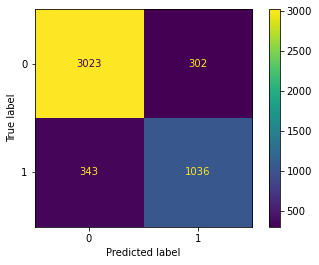

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      3325
           1       0.77      0.75      0.76      1379

    accuracy                           0.86      4704
   macro avg       0.84      0.83      0.83      4704
weighted avg       0.86      0.86      0.86      4704



In [11]:
y_pred = cb.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=cb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=cb.classes_)
disp.plot()
plt.show()
print(classification_report(y_test, y_pred))